# pyPSA-Eur: Aggregation of European data
This file contains 
- the steps to aggregate data from all European countries into one bus
- the steps to remove countries far away from Spain
- the steps to aggregate data from European countries **except** Spain

In [2]:
import pypsa

In [3]:
# Load elec_s_1024.nc
filename = '../networks/elec_s_1024.nc'
n = pypsa.Network()
n.import_from_netcdf(filename)

INFO:pypsa.io:Imported network elec_s_1024.nc has buses, carriers, generators, lines, links, loads, storage_units


In [4]:
n.set_snapshots([n.snapshots[12]])

In [5]:
# Give all unique values for all the variables in a bus
for col in n.buses.columns:
    print(col, n.buses[col].unique())

v_nom [380.]
x [19.89791366  9.69314567 15.871811   ... 17.072754   19.958038
 18.66645825]
y [41.58756833 47.38034967 47.1222125  ... 48.1833715  48.380882
 49.085065  ]
country ['AL' 'AT' 'BA' 'BE' 'BG' 'CH' 'CZ' 'DE' 'DK' 'EE' 'ES' 'FI' 'FR' 'GB'
 'GR' 'HR' 'HU' 'IE' 'IT' 'LT' 'LU' 'LV' 'ME' 'MK' 'NL' 'NO' 'PL' 'PT'
 'RO' 'RS' 'SE' 'SI' 'SK']
control ['Slack' 'PQ']
generator ['AL1 0 offwind-ac' '' 'DK2 0 CCGT' 'EE6 0 CCGT' 'ES4 0 CCGT' 'GB0 0 CCGT'
 'GB5 0 biomass' 'IT3 0 coal']
type ['']
carrier ['AC']
unit ['']
v_mag_pu_set [1.]
v_mag_pu_min [0.]
v_mag_pu_max [inf]
sub_network ['']


So the bus values differ for:
- x,y, country
- control
- generator

and the rest is constant. Hence, in aggregation, we can take the average location and assign a country's virtual bus to it.

In [340]:
# Aggregate all buses into one
m = n.copy()    # Copy network for aggregation and nodal of all countries

# Get mapping of bus to country
bus_country = m.buses.country

# Assign end points (loads, generators, storage units) to a country.
# More informally: replace index of bus with country
for c in m.iterate_components(m.one_port_components):
    c.df.bus = c.df.bus.map(bus_country)

    # Remove all rows where the bus is not in the bus_country
    m.mremove(c.name, c.df[~c.df.bus.isin(bus_country)].index)

# Go over all branches and remove the ones that are internal
for c in m.iterate_components(m.branch_components):
    c.df.bus0 = c.df.bus0.map(bus_country)
    c.df.bus1 = c.df.bus1.map(bus_country)
    internal = c.df.bus0 == c.df.bus1
    m.mremove(c.name, c.df.loc[internal].index)


# Get an array of all unique countries
unique_countries = set(m.buses.country)

# Remove Index; 
for c in unique_countries:
    
    # Get all buses in the country
    buses_in_country = m.buses[m.buses.country == c]

    # Calculate the mean of the x and y coordinates
    x_mean = buses_in_country["x"].mean()
    y_mean = buses_in_country["y"].mean()

    # Remove all buses in the country
    m.mremove("Bus", buses_in_country.index)
    
    # Add a new bus with the mean coordinates
    m.add("Bus", c, x = x_mean, y = y_mean)
    
    # Set country variable; could not be done in add function
    m.buses.at[c, "country"] = c 


(<matplotlib.collections.PatchCollection at 0x24e0e95b910>,
 <matplotlib.collections.LineCollection at 0x24e0e967950>)

c:\Users\ameld\anaconda3\envs\pypsa\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



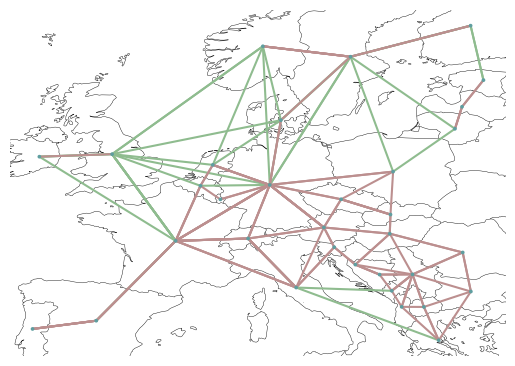

In [341]:
# List the variable names
m.plot()

# Filter on countries close to Spain
Now, we only select the countries that are within 2 connections. We can spot them from the plot above.
We could also do this algorithmically, but proof left to reader ;)

In [342]:
# Countries that are a maximum of 2 hops away from Spain
close_to_spain = ["ES","PT","FR","IE","GB","BE","DE","CH","IT"] # could determine this with algorithm instead'

# Remove all rows where the bus is not close to spain
for c in m.iterate_components(m.one_port_components):
    m.mremove(c.name, c.df[~c.df.bus.isin(close_to_spain)].index)

# Remove all rows where not one of the buses is not close to spain
for c in m.iterate_components(m.branch_components):
    m.mremove(c.name, c.df[~c.df.bus0.isin(close_to_spain) | ~c.df.bus1.isin(close_to_spain)].index)

# Filter network to only include buses close to Spain
m.buses = m.buses[m.buses.country.isin(close_to_spain)]

(<matplotlib.collections.PatchCollection at 0x24e0e9f5190>,
 <matplotlib.collections.LineCollection at 0x24e0fa52750>)

c:\Users\ameld\anaconda3\envs\pypsa\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



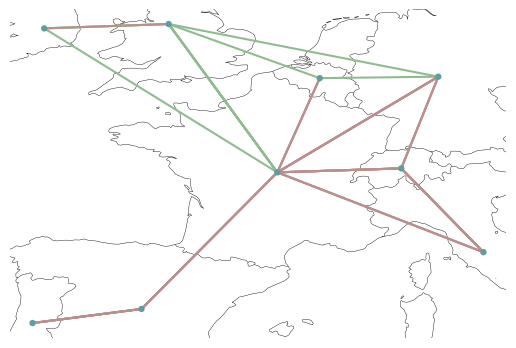

In [343]:
m.plot()

# Keep Spanish Nodes:

In [344]:
n.buses.index[n.buses.country == "ES"].unique

<bound method Index.unique of Index(['ES1 0', 'ES1 1', 'ES1 10', 'ES1 11', 'ES1 12', 'ES1 13', 'ES1 14',
       'ES1 15', 'ES1 16', 'ES1 17', 'ES1 18', 'ES1 19', 'ES1 2', 'ES1 20',
       'ES1 21', 'ES1 22', 'ES1 23', 'ES1 24', 'ES1 25', 'ES1 26', 'ES1 27',
       'ES1 28', 'ES1 29', 'ES1 3', 'ES1 30', 'ES1 31', 'ES1 32', 'ES1 33',
       'ES1 34', 'ES1 35', 'ES1 36', 'ES1 37', 'ES1 38', 'ES1 39', 'ES1 4',
       'ES1 40', 'ES1 41', 'ES1 42', 'ES1 43', 'ES1 44', 'ES1 45', 'ES1 46',
       'ES1 47', 'ES1 48', 'ES1 49', 'ES1 5', 'ES1 50', 'ES1 51', 'ES1 52',
       'ES1 53', 'ES1 54', 'ES1 55', 'ES1 56', 'ES1 57', 'ES1 58', 'ES1 59',
       'ES1 6', 'ES1 60', 'ES1 61', 'ES1 62', 'ES1 63', 'ES1 64', 'ES1 65',
       'ES1 66', 'ES1 67', 'ES1 68', 'ES1 69', 'ES1 7', 'ES1 70', 'ES1 71',
       'ES1 72', 'ES1 73', 'ES1 74', 'ES1 75', 'ES1 76', 'ES1 8', 'ES1 9',
       'ES4 0', 'ES4 1'],
      dtype='object', name='Bus')>

All buses contain ES. We can use this for filtering later on.

In [345]:
o = n.copy()

# Correct approach to assign the index to the 'country' column for buses in Spain, so that it gets treated like a seperate node later on.
o.buses.loc[o.buses.country == "ES", 'country'] = o.buses.loc[o.buses.country == "ES"].index

# Get mapping of bus to country
bus_country = o.buses.country
print(bus_country[bus_country == "ES1 1"])

Bus
ES1 1    ES1 1
Name: country, dtype: object


In [346]:
# Assign end points (loads, generators, storage units) to a country.
# More informally: replace index of bus with country
for c in o.iterate_components(m.one_port_components):

    # spanish_buses = c.df[c.df.bus.isin(["ES"])]

    c.df.bus = c.df.bus.map(bus_country)

    # Remove all rows where the bus is not in the bus_country
    o.mremove(c.name, c.df[~c.df.bus.isin(bus_country)].index)

    # Add the spanish buses back
    # o.madd(spanish_buses, spanish_buses.index)

# Go over all branches and remove the ones that are internal
for c in o.iterate_components(o.branch_components):
    c.df.bus0 = c.df.bus0.map(bus_country)
    c.df.bus1 = c.df.bus1.map(bus_country)
    internal = c.df.bus0 == c.df.bus1
    o.mremove(c.name, c.df.loc[internal].index)


# Get an array of all unique countries
unique_countries = set(o.buses.country)

# Remove Index; 
for c in unique_countries:
    if not "ES" in c: # Skip Buses within Spain
        # Get all buses in the country
        buses_in_country = o.buses[o.buses.country == c]

        # Calculate the mean of the x and y coordinates
        x_mean = buses_in_country["x"].mean()
        y_mean = buses_in_country["y"].mean()

        # Remove all buses in the country
        o.mremove("Bus", buses_in_country.index)
        
        # Add a new bus with the mean coordinates
        o.add("Bus", c, x = x_mean, y = y_mean)
        
        # Set country variable; could not be done in add function
        o.buses.at[c, "country"] = c 

(<matplotlib.collections.PatchCollection at 0x24e09c5cf90>,
 <matplotlib.collections.LineCollection at 0x24e09bd1a90>)

c:\Users\ameld\anaconda3\envs\pypsa\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



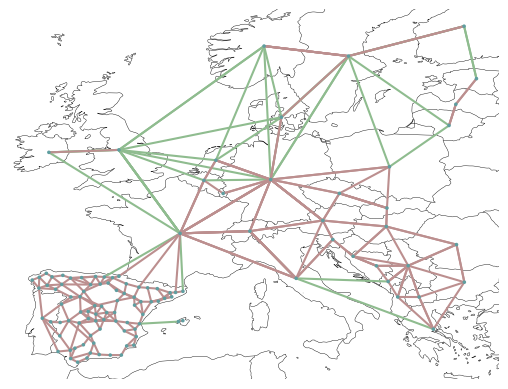

In [347]:
o.plot()

# Filter on countries close to Spain
Now, we only select the countries that are within 2 connections.

In [348]:
# Countries that are a maximum of 2 hops away from Spain
close_to_spain = ["PT","FR","IE","GB","BE","DE","CH","IT"] # could determine this with an algorithm instead

# Add Spain's individual nodes to the list
spain = [s for s in bus_country if "ES" in s] # Get all buses in Spain
close_to_spain += spain

# Remove all rows where the bus is not close to spain
for c in o.iterate_components(o.one_port_components):
    o.mremove(c.name, c.df[~c.df.bus.isin(close_to_spain)].index)

# Remove all rows where not one of the buses is not close to spain
for c in o.iterate_components(o.branch_components):
    o.mremove(c.name, c.df[~c.df.bus0.isin(close_to_spain) | ~c.df.bus1.isin(close_to_spain)].index)

# Filter network to only include buses close to Spain
o.buses = o.buses[o.buses.country.isin(close_to_spain)]

(<matplotlib.collections.PatchCollection at 0x24e09c0fa90>,
 <matplotlib.collections.LineCollection at 0x24e09c7c050>)

c:\Users\ameld\anaconda3\envs\pypsa\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



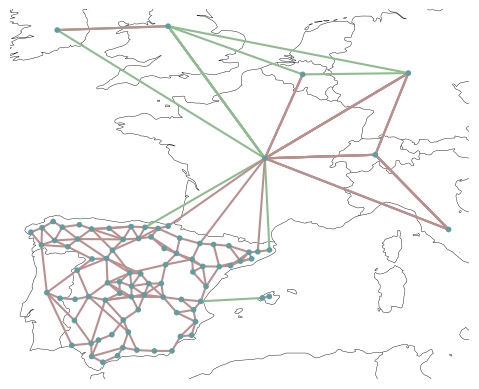

In [349]:
o.plot()